<a href="https://colab.research.google.com/github/alickd/SEP740_DLProject/blob/main/Text_Summarization_Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

Text Summarizer 

Dylan Alick & Jonathan Wong 

In [ ]:
#Install transformers for pre-trained Hugging Face Libraries
!pip install transformers
!pip install sumy

In [ ]:
# Moutning Google Drive to be 
from google.colab import drive
drive.mount('/content/drive')

In [11]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import re
import string
from keras.preprocessing.text import Tokenizer 
from keras import backend as K

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

import gensim
from gensim.summarization import summarize
from gensim.parsing.preprocessing import remove_stopwords

from tensorflow import keras
from keras.utils.data_utils import pad_sequences
import keras_preprocessing
from keras.preprocessing import text,sequence
from keras.models import Model
from keras.layers import Input,Dense,Embedding,LSTM,Dropout, RepeatVector, concatenate, TimeDistributed
from tensorflow.keras.layers import Attention

from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
#Import and read dataset
path  = "/content/drive/MyDrive/Deep Learning Project/Reviews.xlsx"
#Reducing data size due to computational limitations, dataset size = 100k
df_reviews = pd.read_csv(path,nrows=100000)
#Drop columns not needed for model
df_reviews.drop(columns=['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time'],inplace=True,axis=1)
df_reviews.dropna(axis=0,inplace=True)
df_reviews.head(5)

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


LSA Machine Learning Model Summary

In [14]:
# Import the summarizer 
import sumy
from sumy.summarizers.lsa import LsaSummarizer 

# Text to summarize 
lst_summaries = []
lsa_summary = []

lst_summaries=[df_reviews['Text'][1],df_reviews['Text'][2]]

# Parsing the text string using PlaintextParser 
from sumy.nlp.tokenizers import Tokenizer 
from sumy.parsers.plaintext import PlaintextParser 

parser=PlaintextParser.from_string(lst_summaries,Tokenizer('english')) 

# Creating the summarizer 
lsa_summarizer=LsaSummarizer()
lsa_summary= lsa_summarizer(parser.document,1)

# Printing the summary 
print(lst_summaries[0])
print("---------------------------------------------------------------------")
print("Summary")
for sentence in lsa_summary: 
    print(sentence) 

Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
---------------------------------------------------------------------
Summary
It is a light, pillowy citrus gelatin with nuts - in this case Filberts.


Pre-Processing Text Data

In [31]:
print("Before Pre-Processing")
#Printing first three rows of original reviews and summary
for i in range(3):
  print("Review ", i+1)
  print(df_reviews['Text'][i])
  print("Summary")
  print(df_reviews['Summary'][i])

Before Pre-Processing
Review  1
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Summary
Good Quality Dog Food
Review  2
Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
Summary
Not as Advertised
Review  3
This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat th

In [17]:
#Function created to clean text as part of preprocessing data - includes removing numbers, punctuation, special characters, and stopwords
def clean_text(text):
  #Removing numbers
  text = re.sub('[^a-zA-Z]', ' ', text)
  #Convert text into lower case
  text = text.lower()
  #Remove URL links
  text = re.sub(r'http\S+',' ',text)
  #Removing extra spaces/lines
  text = re.sub(' +',' ',text)
  #Removing punctuation and characters
  text = re.sub('[^\w\s]','',text)
  #Removing stopwords
  text = remove_stopwords(text)
  return text

In [33]:
#Pre-Processing Text Data
df_reviews["Summary"] = df_reviews["Summary"].apply(clean_text)
df_reviews["Text"] = df_reviews["Text"].apply(clean_text)

In [19]:
#For Seq2Seq model, adding a start and end token for processing
df_reviews['Text'] = df_reviews['Text'].apply(lambda x : 'start '+ x + ' end')

In [36]:
print("After Pre-Processing")
for i in range(3):
  print("Review ", i+1)
  print(df_reviews['Text'][i])
  print("Summary")
  print(df_reviews['Summary'][i])

After Pre-Processing
Review  1
bought vitality canned dog food products good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary
good quality dog food
Review  2
product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary
advertised
Review  3
confection centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story c s lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary
delight says


Visualize the Data

In [ ]:
import itertools
import collections

lemmatized_tokens = list(df_reviews["Summary"])
token_list = list(itertools.chain(lemmatized_tokens))

#Frequency of Words Plot
counts_no=collections.Counter(token_list)
clean_words = pd.DataFrame(counts_no.most_common(30),columns=['text','count'])
fig,ax = plt.subplots(figsize=(8,8))
clean_words.sort_values(by='count').plot.barh(x='text',y='count',ax=ax,color='green')
ax.set_title("Frequency of Words")
plt.show()

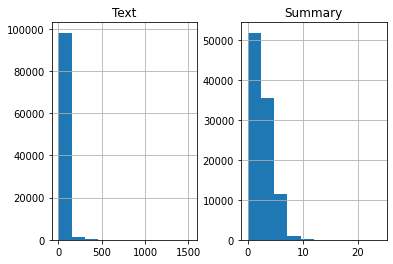

In [27]:
#Plotting distrubution of word count for reviews vs summary
text_word_count = []
summary_word_count = []

#Populate the lists with sentence lengths
for i in df_reviews['Text']:
      text_word_count.append(len(i.split()))

for i in df_reviews['Summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Text':text_word_count, 'Summary':summary_word_count})

length_df.hist()
plt.show()

In [ ]:
MAX_LEN_TEXT = 80
MAX_LEN_SUM = 15

In [ ]:
from sklearn.model_selection import train_test_split

X_text = list(df_reviews['Text'].values)
y_summary = list(df_reviews['Summary'].values)
reviews = df_reviews['Text']
labels = df_reviews['Summary']

train_reviews, val_reviews, train_labels, val_labels = train_test_split(reviews, labels, test_size=.3)
X_train,X_test,Y_train,Y_test=train_test_split(X_text,y_summary,test_size=0.2,shuffle=True)

In [ ]:
#Tokenization
from keras_preprocessing.text import Tokenizer

x_tokenizer = Tokenizer()
y_tokenizer = Tokenizer()


x_tokenizer.fit_on_texts(list(X_train))
y_tokenizer.fit_on_texts(list(Y_train))

#Tokenize Train - convert text sequences to integer sequences
x_train_token = x_tokenizer.texts_to_sequences(X_train)
y_train_token = y_tokenizer.texts_to_sequences(Y_train)

#Padding zeros up to the maximum length of text so all is same
x_train = pad_sequences(x_train_token, maxlen = MAX_LEN_TEXT, padding = 'post')
y_train = pad_sequences(y_train_token, maxlen = MAX_LEN_TEXT, padding = 'post')

#Tokenize Test
x_test_token = x_tokenizer.texts_to_sequences(X_test)
y_test_token = y_tokenizer.texts_to_sequences(Y_test)

#Padding zeros up to the maximum length of text so all is same
x_test = pad_sequences(x_test_token, maxlen = MAX_LEN_TEXT)
y_test = pad_sequences(y_test_token, maxlen = MAX_LEN_TEXT)

x_voc_size = len(x_tokenizer.word_index)+1
y_voc_size= len(y_tokenizer.word_index)+1

print(X_train[1]) #text data
print(Y_train[1])
print(x_train.shape) #text data in tokens
print(y_train.shape)

In [ ]:
K.clear_session()
latent_dim = 500

In [ ]:
# Encoder
encoder_inputs = Input(shape=(MAX_LEN_TEXT,))
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_inputs)

# LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm1(encoder_output1)

# LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm1(encoder_output2)

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc_size, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_ouputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention layer
#attn_layer = Attention(name='attention_layer')
#attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Dense Layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_ouputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs,name='Seq2Seq')


In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics='accuracy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history = model.fit([x_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                  epochs=5, batch_size=512, verbose =2,
                  validation_data=([x_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
reverse_target_word_index = y_tokenizer.index_word 
reverse_source_word_index = x_tokenizer.index_word 
target_word_index = y_tokenizer.word_index

In [ ]:
# Encoder inference
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(MAX_LEN_TEXT, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention inference ??

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index["start"]

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
          decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (MAX_LEN_SUMMARY-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if ((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if (i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(10):
  print("Review:",seq2text(x_test[i]))
  print("Original summary:",seq2summary(y_test[i]))
  print("Predicted summary:",decode_sequence(x_test[i].reshape(1, MAX_LEN_TEXT)))
  print("\n")

Hugging Face Transformers - Pretrained Model

In [ ]:
import transformers
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DataCollatorForSeq2Seq
from transformers import TFTrainer, TFTrainingArguments
from transformers import Seq2SeqTrainer

from transformers import TrainingArguments, Trainer

mdl = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
#model = TFAutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
train_encodings = tokenizer(X_train, truncation = True, padding = True)
val_encodings = tokenizer(Y_train, truncation= True, padding = True)
test_encodings = tokenizer(Y_test, truncation = True, padding = True)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    X_train
))

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    Y_test
))

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=mdl,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    #data_collator=data_collator,
)


In [ ]:
trainer.train()

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer, return_tensors="tf")

In [ ]:
tf_train_dataset = tokenized_dataset['train'].to_tf_dataset(
    columns=['attention_mask', 'input_ids'],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=['attention_mask', 'input_ids'],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [ ]:
from transformers import create_optimizer
import tensorflow as tf

batch_size = 16
num_epochs = 5
batches_per_epoch = len(tokenized_dataset["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(
    init_lr=2e-5, 
    num_warmup_steps=0, 
    num_train_steps=total_train_steps
)

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
lst_summaries=[]
for i in range (X_train):
  lst_summaries = X_train[i]

In [ ]:
print(lst_summaries)

In [ ]:
predicted = bart

In [ ]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

In [ ]:
sum_generated = summarizer(df_reviews['Text'][1])
print(sum_generated)

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
dataset = load_dataset("csv", data_files="/content/drive/MyDrive/Deep Learning Project/Reviews.csv")

In [ ]:
dataset['train'][1]

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["Text"], truncation=True)

In [ ]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import AutoModelForSequenceClassification
mod = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer, return_tensors="tf")

In [ ]:
tf_train_dataset = tokenized_dataset['train'].to_tf_dataset(
    columns=['attention_mask', 'input_ids','Summary'],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=['attention_mask', 'input_ids','Time'],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [ ]:
from transformers import create_optimizer
import tensorflow as tf

batch_size = 16
num_epochs = 5
batches_per_epoch = len(tokenized_dataset["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(
    init_lr=2e-5, 
    num_warmup_steps=0, 
    num_train_steps=total_train_steps
)

In [ ]:
from transformers import TFAutoModelForSequenceClassification
wuk = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

In [ ]:
import tensorflow as tf
wuk.compile(optimizer=optimizer)

In [ ]:
wuk.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=5,
    verbose=2
)